![logo](https://github.com/heberrossi/Curso_CientistaDeDados_EBAC_Exercicios/blob/main/logo/ebac_logo-data_science.png?raw=true)


# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [2]:
# Se a coluna de data não estiver no formato datetime, converta-a
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criar a variável dia da semana
df['dia_da_semana'] = df['Data Emissão'].dt.day_name()  # 0 = Segunda-feira, 6 = Domingo

# Criar a variável dummy para fim de semana
df['fim_de_semana'] = df['dia_da_semana'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Criar a variável dia do mês
df['dia_do_mes'] = df['Data Emissão'].dt.day

# Criar a variável mês
df['mes'] = df['Data Emissão'].dt.month

# Criar a variável trimestre
df['trimestre'] = df['Data Emissão'].dt.quarter

# Verificar as primeiras linhas do DataFrame com as novas variáveis
df

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,dia_da_semana,fim_de_semana,dia_do_mes,mes,trimestre
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,Friday,0,30,6,2
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,Friday,0,30,6,2
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,Friday,0,30,6,2
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,Friday,0,30,6,2
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,Friday,0,30,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.00,Liberado,2021,2,0.000000,0,não definido,Thursday,0,7,1,1
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Mercado,Thursday,0,7,1,1
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Farmácia,Thursday,0,7,1,1
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Mercado,Thursday,0,7,1,1


In [3]:
# Criar categorias por quantis
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], 5, labels=False)
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], 10, labels=False)
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], 20, labels=False)
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], 50, labels=False)
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,dia_da_semana,fim_de_semana,dia_do_mes,mes,trimestre,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Mercado,Friday,0,30,6,2,1,3,7,17
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Auto posto,Friday,0,30,6,2,2,5,11,28
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Restaurantes,Friday,0,30,6,2,1,3,7,19
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Restaurantes,Friday,0,30,6,2,3,7,15,38
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Restaurantes,Friday,0,30,6,2,3,7,15,39


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [4]:
df_ = df.drop(columns=['Data Emissão',
                       'CNPJ emit.',
                       'Emitente',
                       'No.',
                       'Valor NF',
                       'Data Registro',
                       'Créditos',
                       'Situação do Crédito',
                       'Retorno',
                       ])

In [5]:
df_2020 = df_[df_['Ano'] >= 2020]
df_2020

,Ano,Semestre,flag_credito,categoria,dia_da_semana,fim_de_semana,dia_do_mes,mes,trimestre,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
100702,2020,1,0,Farmácia,Tuesday,0,30,6,2,4,8,17,42
100703,2020,1,0,não definido,Tuesday,0,30,6,2,3,6,12,31
100704,2020,1,0,não definido,Tuesday,0,30,6,2,4,9,18,47
100705,2020,1,0,Farmácia,Tuesday,0,30,6,2,2,5,11,29
100706,2020,1,0,Varejo,Tuesday,0,30,6,2,2,4,8,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,2021,2,0,não definido,Thursday,0,7,1,1,4,8,17,44
187642,2021,2,0,Mercado,Thursday,0,7,1,1,4,9,18,46
187643,2021,2,0,Farmácia,Thursday,0,7,1,1,3,7,15,39
187644,2021,2,0,Mercado,Thursday,0,7,1,1,2,5,10,26


In [6]:
metadados = pd.DataFrame({'dtype':df_2020.dtypes})
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito', 'papel'] = 'resposta'
metadados['nunique'] = df_.nunique()
metadados

,dtype,papel,nunique
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
dia_da_semana,object,covariavel,7
fim_de_semana,int64,covariavel,2
dia_do_mes,int32,covariavel,31
mes,int32,covariavel,12
trimestre,int32,covariavel,4
valor_nf_q5,int64,covariavel,5


In [7]:
def IV(variavel, resposta):
    """
    Calcula o Information Value (IV) para uma variável categórica.

    Args:
    variavel (pd.Series): A variável categórica.
    resposta (pd.Series): A variável alvo binária.

    Returns:
    float: O valor de Information Value (IV).
    """
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento] / tab.loc['total', rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento] / tab.loc['total', rótulo_nao_evento]
    tab['WOE'] = np.log(tab['pct_evento'] / tab['pct_nao_evento'])
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento) * tab.WOE
    return tab['iv_parcial'].sum()


In [8]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique'] > 9):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_2020[var], 5, duplicates='drop'), df_.flag_credito)
    else:
        metadados.loc[var, 'IV'] = IV(df_2020[var], df_2020.flag_credito)

metadados.sort_values(by='IV', ascending=False)

metadados

,dtype,papel,nunique,IV
Ano,int64,covariavel,5,0.003168
Semestre,int64,covariavel,2,0.004906
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.279071
dia_da_semana,object,covariavel,7,0.005860
fim_de_semana,int64,covariavel,2,0.004579
dia_do_mes,int32,covariavel,31,0.003568
mes,int32,covariavel,12,0.003666
trimestre,int32,covariavel,4,0.003581
valor_nf_q5,int64,covariavel,5,0.043787


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

De acordo com a tabela abaixo, a variável com maior poder é a variável Categoria

In [9]:
metadados.loc[metadados['IV'] < 0.02, 'poder_preditivo'] = 'Inútil'
metadados.loc[(metadados['IV'] >= 0.02) & (metadados['IV'] < 0.1), 'poder_preditivo'] = 'Fraco'
metadados.loc[(metadados['IV'] >= 0.1) & (metadados['IV'] < 0.3), 'poder_preditivo'] = 'Médio'
metadados.loc[(metadados['IV'] >= 0.3) & (metadados['IV'] < 0.5), 'poder_preditivo'] = 'Forte'
metadados.loc[metadados['IV'] >= 0.5, 'poder_preditivo'] = 'Previsibilidade suspeita (pode indicar overfitting)'
metadados.sort_values(by='IV', ascending=False)
metadados

,dtype,papel,nunique,IV,poder_preditivo
Ano,int64,covariavel,5,0.003168,Inútil
Semestre,int64,covariavel,2,0.004906,Inútil
flag_credito,int64,resposta,2,NaN,NaN
categoria,object,covariavel,9,0.279071,Médio
dia_da_semana,object,covariavel,7,0.005860,Inútil
fim_de_semana,int64,covariavel,2,0.004579,Inútil
dia_do_mes,int32,covariavel,31,0.003568,Inútil
mes,int32,covariavel,12,0.003666,Inútil
trimestre,int32,covariavel,4,0.003581,Inútil
valor_nf_q5,int64,covariavel,5,0.043787,Fraco


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

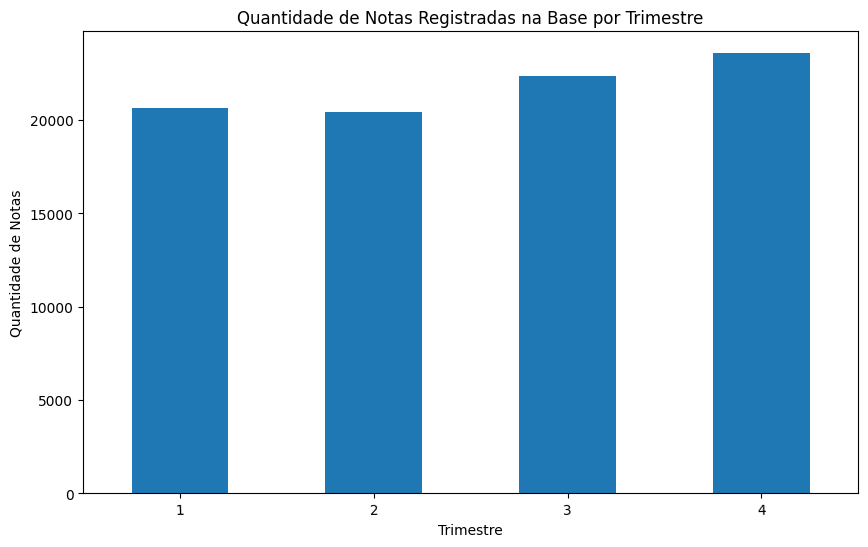

In [10]:
# Quantidade de notas por trimestre
quantidade_notas_trimestre = df_2020.groupby('trimestre').size()

# Plotar a quantidade de notas registradas por período
plt.figure(figsize=(10, 6))
quantidade_notas_trimestre.plot(kind='bar')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas Registradas na Base por Trimestre')
plt.xticks(rotation=2)
plt.show()

In [11]:
# Quantidade de notas por categoria e por trimestre
quantidade_notas_categoria_trimestre = df_2020.groupby(['trimestre', 'categoria']).size().unstack(fill_value=0)

# Calcular a quantidade total de notas por categoria
quantidade_notas_categoria = df_2020.groupby('categoria').size()

# Adicionar a coluna de total à tabela de quantidade de notas por categoria e por trimestre
quantidade_notas_categoria_trimestre['Total'] = quantidade_notas_trimestre

# Adicionar a linha de total por categoria
quantidade_notas_categoria_trimestre.loc['Total por Categoria'] = quantidade_notas_categoria
quantidade_notas_categoria_trimestre.loc['Total por Categoria', 'Total'] = quantidade_notas_categoria.sum()

quantidade_notas_categoria_trimestre

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido,Total
trimestre,,,,,,,,,,
1,1279.0,151.0,3853.0,2429.0,6725.0,753.0,949.0,429.0,4087.0,20655.0
2,1167.0,116.0,3806.0,2492.0,6555.0,426.0,1266.0,426.0,4144.0,20398.0
3,1227.0,136.0,4079.0,2569.0,7093.0,513.0,1340.0,456.0,4925.0,22338.0
4,1374.0,136.0,4308.0,2696.0,7183.0,486.0,1511.0,609.0,5250.0,23553.0
Total por Categoria,5047.0,539.0,16046.0,10186.0,27556.0,2178.0,5066.0,1920.0,18406.0,86944.0


In [12]:
quantidade_notas_categoria_trimestre.drop(columns=['Total'], inplace=True)
quantidade_notas_categoria_trimestre.drop(index=['Total por Categoria'], inplace=True)
quantidade_notas_categoria_trimestre

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
trimestre,,,,,,,,,
1,1279.0,151.0,3853.0,2429.0,6725.0,753.0,949.0,429.0,4087.0
2,1167.0,116.0,3806.0,2492.0,6555.0,426.0,1266.0,426.0,4144.0
3,1227.0,136.0,4079.0,2569.0,7093.0,513.0,1340.0,456.0,4925.0
4,1374.0,136.0,4308.0,2696.0,7183.0,486.0,1511.0,609.0,5250.0


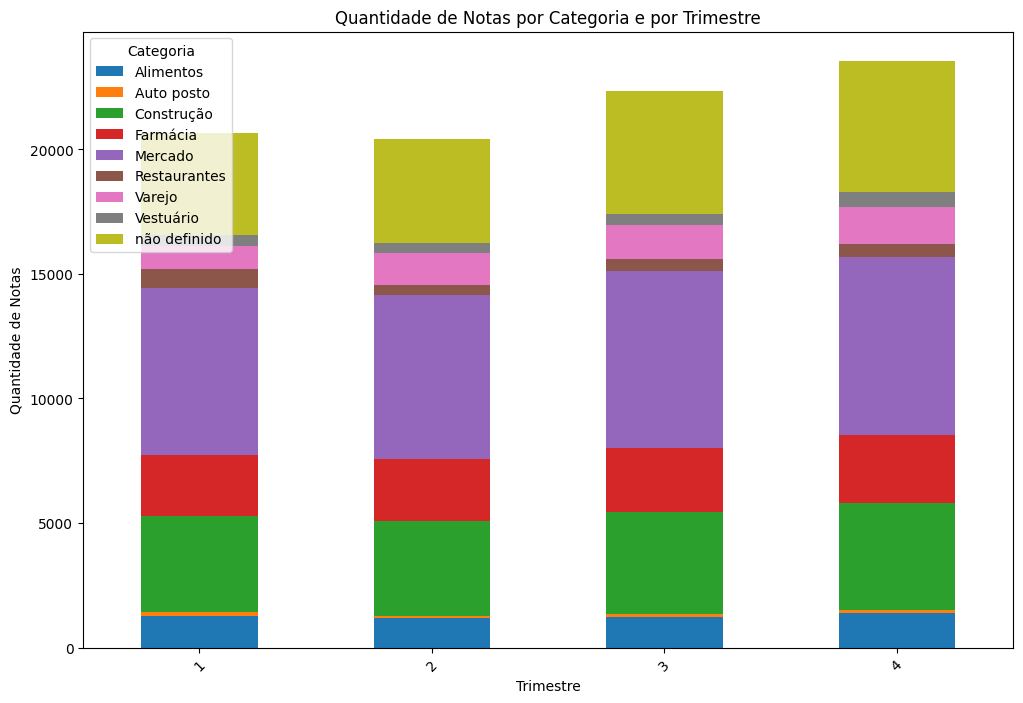

In [13]:
# Plotar a quantidade de notas por categoria e por trimestre
quantidade_notas_categoria_trimestre.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas por Categoria e por Trimestre')
plt.xticks(rotation=45)
plt.legend(title='Categoria')

plt.show()

In [14]:
# Calcular a quantidade de notas com crédito por categoria e por trimestre
#quantidade_notas_credito_categoria_trimestre = df_[df_['flag_credito'] == 1].groupby(['trimestre', 'categoria']).size().unstack(fill_value=0)

quantidade_notas_credito_categoria_trimestre = df_2020.groupby(['trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
quantidade_notas_credito_categoria_trimestre['total'] = quantidade_notas_credito_categoria_trimestre.sum(axis=1)
quantidade_notas_credito_categoria_trimestre['proporcao_credito'] = quantidade_notas_credito_categoria_trimestre[1] / quantidade_notas_credito_categoria_trimestre['total']
quantidade_notas_credito_categoria_trimestre

# Calcular a quantidade total de notas por categoria e por trimestre
#quantidade_total_notas_categoria_trimestre = df_.groupby(['trimestre', 'categoria']).size().unstack(fill_value=0)

# Calcular a proporção de notas com crédito por categoria e por trimestre
#proporcao_credito_categoria_trimestre = quantidade_notas_credito_categoria_trimestre / quantidade_total_notas_categoria_trimestre
#proporcao_credito_categoria_trimestre

flag_credito               0     1  total  proporcao_credito
trimestre categoria                                         
1         Alimentos      371   908   1279           0.709930
          Auto posto     117    34    151           0.225166
          Construção    2042  1811   3853           0.470023
          Farmácia      1791   638   2429           0.262660
          Mercado       3454  3271   6725           0.486394
          Restaurantes   163   590    753           0.783533
          Varejo         777   172    949           0.181243
          Vestuário      314   115    429           0.268065
          não definido  2480  1607   4087           0.393198
2         Alimentos      431   736   1167           0.630677
          Auto posto      88    28    116           0.241379
          Construção    2126  1680   3806           0.441408
          Farmácia      1675   817   2492           0.327849
          Mercado       3453  3102   6555           0.473227
          Restaurantes   127   299    426           0.701878
          Varejo        1118   148   1266           0.116904
          Vestuário      347    79    426           0.185446
          não definido  2802  1342   4144           0.323842
3         Alimentos      378   849   1227           0.691932
          Auto posto      95    41    136           0.301471
          Construção    2075  2004   4079           0.491297
          Farmácia      1626   943   2569           0.367069
          Mercado       3723  3370   7093           0.475116
          Restaurantes   116   397    513           0.773879
          Varejo        1156   184   1340           0.137313
          Vestuário      337   119    456           0.260965
          não definido  3112  1813   4925           0.368122
4         Alimentos      425   949   1374           0.690684
          Auto posto     104    32    136           0.235294
          Construção    2280  2028   4308           0.470752
          Farmácia      1512  1184   2696           0.439169
          Mercado       3749  3434   7183           0.478073
          Restaurantes   146   340    486           0.699588
          Varejo        1314   197   1511           0.130377
          Vestuário      479   130    609           0.213465
          não definido  3323  1927   5250           0.367048

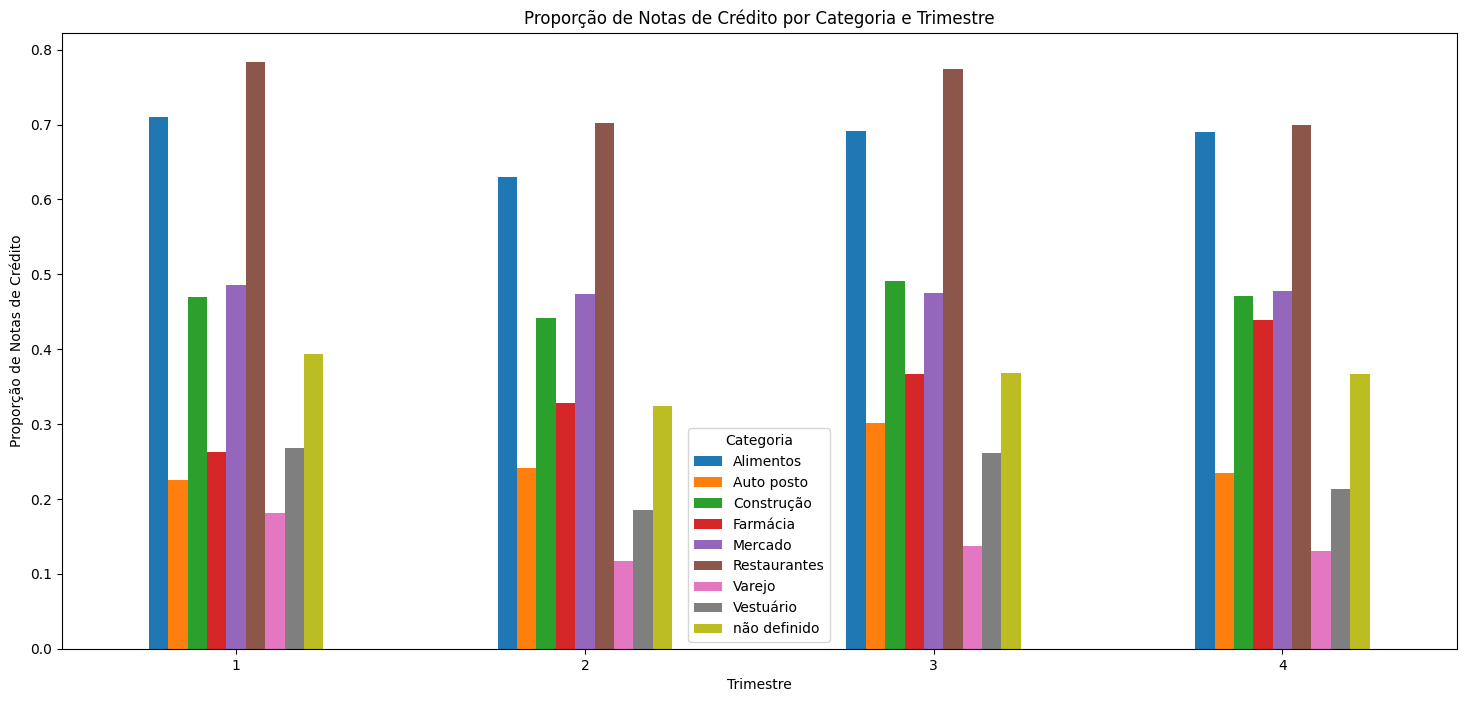

In [15]:
# Reshape para um formato mais adequado para o gráfico
data_plot = quantidade_notas_credito_categoria_trimestre.reset_index().pivot(index='trimestre', columns='categoria', values='proporcao_credito')

# Criar o gráfico
data_plot.plot(kind='bar', figsize=(18, 8))
plt.title('Proporção de Notas de Crédito por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas de Crédito')
plt.legend(title='Categoria')
plt.xticks(rotation=0)
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [16]:
quantidade_notas_credito_categoria_trimestre['pct_evento'] = quantidade_notas_credito_categoria_trimestre[1] / quantidade_notas_credito_categoria_trimestre['total']
quantidade_notas_credito_categoria_trimestre['pct_nao_evento'] = quantidade_notas_credito_categoria_trimestre[0] / quantidade_notas_credito_categoria_trimestre['total']
quantidade_notas_credito_categoria_trimestre['WOE'] = np.log(quantidade_notas_credito_categoria_trimestre['pct_evento'] / quantidade_notas_credito_categoria_trimestre['pct_nao_evento'])
quantidade_notas_credito_categoria_trimestre


flag_credito               0     1  total  proporcao_credito  pct_evento  \
trimestre categoria                                                        
1         Alimentos      371   908   1279           0.709930    0.709930   
          Auto posto     117    34    151           0.225166    0.225166   
          Construção    2042  1811   3853           0.470023    0.470023   
          Farmácia      1791   638   2429           0.262660    0.262660   
          Mercado       3454  3271   6725           0.486394    0.486394   
          Restaurantes   163   590    753           0.783533    0.783533   
          Varejo         777   172    949           0.181243    0.181243   
          Vestuário      314   115    429           0.268065    0.268065   
          não definido  2480  1607   4087           0.393198    0.393198   
2         Alimentos      431   736   1167           0.630677    0.630677   
          Auto posto      88    28    116           0.241379    0.241379   
          Construção    2126  1680   3806           0.441408    0.441408   
          Farmácia      1675   817   2492           0.327849    0.327849   
          Mercado       3453  3102   6555           0.473227    0.473227   
          Restaurantes   127   299    426           0.701878    0.701878   
          Varejo        1118   148   1266           0.116904    0.116904   
          Vestuário      347    79    426           0.185446    0.185446   
          não definido  2802  1342   4144           0.323842    0.323842   
3         Alimentos      378   849   1227           0.691932    0.691932   
          Auto posto      95    41    136           0.301471    0.301471   
          Construção    2075  2004   4079           0.491297    0.491297   
          Farmácia      1626   943   2569           0.367069    0.367069   
          Mercado       3723  3370   7093           0.475116    0.475116   
          Restaurantes   116   397    513           0.773879    0.773879   
          Varejo        1156   184   1340           0.137313    0.137313   
          Vestuário      337   119    456           0.260965    0.260965   
          não definido  3112  1813   4925           0.368122    0.368122   
4         Alimentos      425   949   1374           0.690684    0.690684   
          Auto posto     104    32    136           0.235294    0.235294   
          Construção    2280  2028   4308           0.470752    0.470752   
          Farmácia      1512  1184   2696           0.439169    0.439169   
          Mercado       3749  3434   7183           0.478073    0.478073   
          Restaurantes   146   340    486           0.699588    0.699588   
          Varejo        1314   197   1511           0.130377    0.130377   
          Vestuário      479   130    609           0.213465    0.213465   
          não definido  3323  1927   5250           0.367048    0.367048   

flag_credito            pct_nao_evento       WOE  
trimestre categoria                               
1         Alimentos           0.290070  0.895042  
          Auto posto          0.774834 -1.235813  
          Construção          0.529977 -0.120051  
          Farmácia            0.737340 -1.032191  
          Mercado             0.513606 -0.054437  
          Restaurantes        0.216467  1.286372  
          Varejo              0.818757 -1.507946  
          Vestuário           0.731935 -1.004461  
          não definido        0.606802 -0.433889  
2         Alimentos           0.369323  0.535122  
          Auto posto          0.758621 -1.145132  
          Construção          0.558592 -0.235448  
          Farmácia            0.672151 -0.717929  
          Mercado             0.526773 -0.107196  
          Restaurantes        0.298122  0.856256  
          Varejo              0.883096 -2.022084  
          Vestuário           0.814554 -1.479877  
          não definido        0.676158 -0.736172  
3         Alimentos           0.308068  0.809165  
          Auto posto          0.698529 -

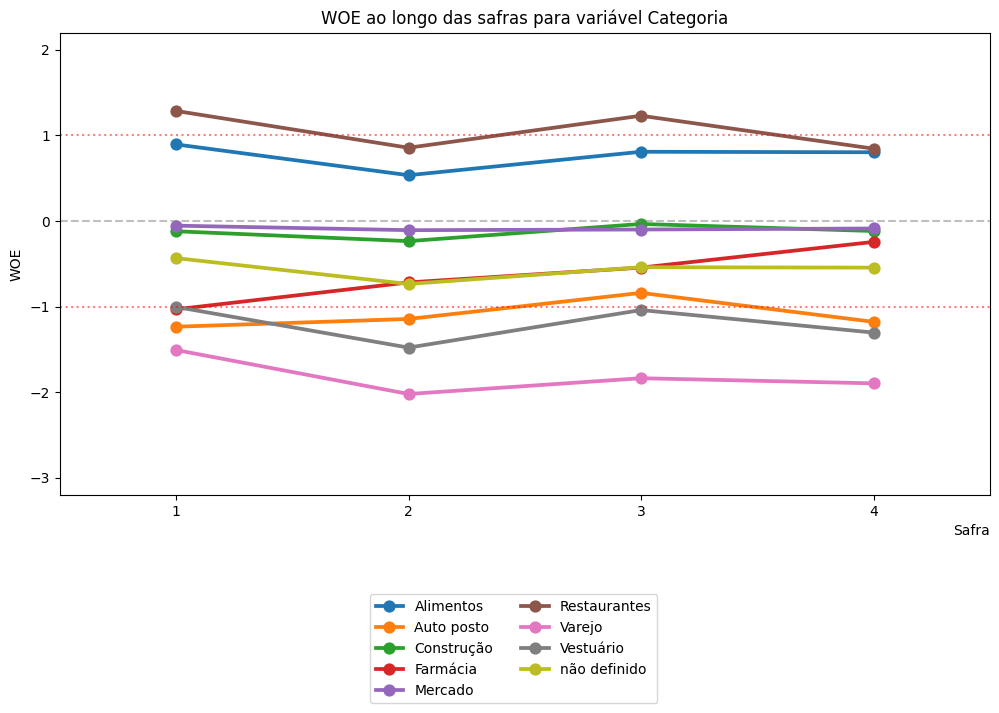

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=quantidade_notas_credito_categoria_trimestre.reset_index(), y = 'WOE', x = 'trimestre', hue=variavel, ax=ax);

# Rotacionar os rótulos do eixo X
labs = quantidade_notas_credito_categoria_trimestre.index.get_level_values(level=0).unique()

ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(2.2, max(quantidade_notas_credito_categoria_trimestre.WOE))
ymin = min(-3.2, min(quantidade_notas_credito_categoria_trimestre.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo das safras para variável {variavel.capitalize()}')
ax.set_xlabel('Safra', loc='right');

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?

     Alimentos e Restaurantes possuem a maior proporção, seguidos de Mercado e Construção

- Essas diferenças são estáveis no tempo?

     Com poucas alterações, mas relativamente estáveis. Podeoms ver pelo gráfico de WOE separando por trimestre, apenas com Farmácia com uma maior variabilidade, indo de -1 de Woe a quase 0

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.
